# Structural Analysis of a Lathe Cutter
## Objective  
The objective of this example is to highlight some of the often-used PyMAPDL categories via a lathe cutter finite element model.  Lathe cutters have multiple avenues of wear and failure, and the analyses supporting their design would most often be transient thermal-structural.  However, for simplicity, we will simulate this with a non-uniform load.

### Procedure  

1 Define necessary variables and launch MAPDL  
2 Import geometry and inspect for MAPDL parameters. Define linear elastic material model with Python variables.  Mesh and apply symmetry boundary conditions  
3 Create a local coordinate system for applied load and verify with plot  
4 Define the pressure load as a sine function of the length of the application area using numpy arrays; import the pressure array into MAPDL as a table array; verify the applied load, and solve  
5 Show result plotting; plotting with selection; and working with the plot legend  
  List a result two ways - PyMAPDL and Pythonic version of APDL showing extended method; write list to a file.  
6 Use of mesh.grid for additional post processing

# Step 1
Define variables and luanch MAPDL

In [1]:
import os
import numpy as np
from ansys.mapdl.core import launch_mapdl

# cwd = current working directory

path = os.getcwd()
PI = np.pi
EXX = 1.0E7
NU = 0.27

mapdl = launch_mapdl(run_location=path, additional_switches='-smp')

# Step 2

Import geometry and inspect for MAPDL parameters

Define material, mesh, and create boundary conditions

In [2]:
# reset the MAPDL database
mapdl.clear()

# import the geometry file and list any MAPDL parameters
mapdl.input("LatheCutter.anf")
mapdl.finish()
mapdl.parameters

MAPDL Parameters
----------------
PRESS_LENGTH                     : 0.055
UNIT_SYSTEM                      : "bin"

In [3]:
# Will use pressure area length in load definition so save as Python variable

pressure_length = mapdl.parameters['PRESS_LENGTH']

mapdl.units('Bin')
mapdl.title('Lathe Cutter')
mapdl.prep7()

mapdl.mp("EX", 1, EXX)
mapdl.mp("NUXY", 1, NU)

mapdl.et(1, 285)
mapdl.smrtsize(4)
mapdl.aesize(14, 0.0025)
mapdl.vmesh(1)

mapdl.da(11, 'symm')
mapdl.da(16, 'symm')
mapdl.da(9, 'symm')
mapdl.da(10, 'symm')

CONSTRAINT AT AREA    10
      LOAD LABEL = SYMM

# Step 3

Create Local Coordinate System (CS) for Applied Pressure as a Function of Local X

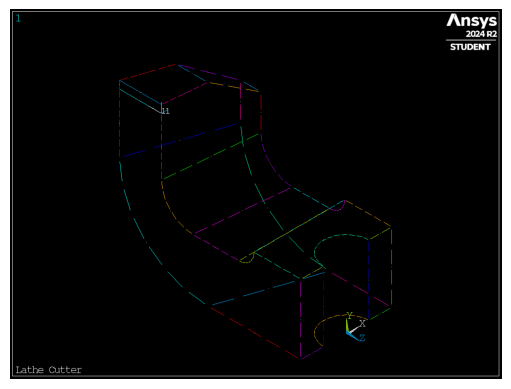

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
# Local CS ID is 11

mapdl.cskp(11, 0, 2, 1, 13)
mapdl.csys(1)
mapdl.view(1, -1, 1, 1)
mapdl.psymb('CS', 1)
# mapdl.vplot(color_areas=True, show_lines=True, cpos=[-1, 1, 1])

mapdl.lplot(vtk=False)

# Step 4

Create pressure, load it into MAPDL as a Table array, verify the load, and solve

In [5]:
# pressure_length = 0.055 inch

pts = 10
pts_1 = pts - 1

length_x = np.arange(0, pts, 1)
length_x = length_x * pressure_length / pts_1

press = 10000 * np.sin(PI * length_x / pressure_length)

# length_x and press are vectors; can use Numpy stack function to combine them into the correct form needed to define the MAPDL table array

press = np.stack((length_x, press), axis=-1)
# print(press)

mapdl.load_table("MY_PRESS", press, "X", csysid=11)

mapdl.asel("S", "Area", "", 14)
mapdl.nsla("S", 1)
mapdl.sf("All", "Press", "%MY_PRESS%")
mapdl.allsel()

SELECT ALL ENTITIES OF TYPE= ALL  AND BELOW

In [6]:
# mapdl.open_gui()

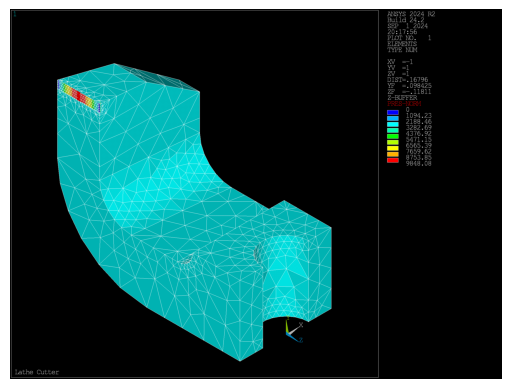

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
mapdl.finish()
mapdl.slashsolu()
mapdl.nlgeom("On")
mapdl.psf("PRES", "NORM", 3, 0, 1)
mapdl.view(1, -1, 1, 1)
mapdl.eplot(vtk=False)

In [8]:
mapdl.solve()
mapdl.finish()
mapdl.solution.converged

True

# Step 5
## PostProcessing - Plotting

In [9]:
mapdl.post1()
mapdl.set("last")
mapdl.allsel()

SELECT ALL ENTITIES OF TYPE= ALL  AND BELOW

In [10]:
mapdl.post_processing.plot_nodal_principal_stress("1", smooth_shading=False)

Widget(value='<iframe src="http://localhost:7432/index.html?ui=P_0x185e7127170_0&reconnect=auto" class="pyvist…

## Plotting - Part of Model

In [11]:
mapdl.csys(1)
mapdl.nsel('S', 'LOC', 'Z', -.5, -.141)
mapdl.esln()
mapdl.nsle()
mapdl.post_processing.plot_nodal_principal_stress('1', edge_color='white', show_edges=True)

Widget(value='<iframe src="http://localhost:7432/index.html?ui=P_0x185e87fb7a0_1&reconnect=auto" class="pyvist…

## Plotting - Legend Options

In [12]:
mapdl.allsel()
sbar_kwargs = {"color": "black", "title": "1st Principal Stress (psi)", "vertical": False, "n_labels": 6}
mapdl.post_processing.plot_nodal_principal_stress("1", cpos="xy", background="white", edge_color="black", show_edges=True, scalar_bar_args=sbar_kwargs, n_colors=9)

Widget(value='<iframe src="http://localhost:7432/index.html?ui=P_0x185e88d68d0_2&reconnect=auto" class="pyvist…

## Post Processing - Result Listing

In [13]:
mapdl.post_processing.nodal_principal_stress('1')

array([ 848.18096944, 1190.88042106,  120.39884077, ..., 2286.79771311,
       1485.25229   , 1507.10368052])

In [14]:
mapdl.nsel("S", "S", 1, 6700, 7720)
mapdl.esln()
mapdl.nsle()

mapdl.mesh.nnum

array([ 84,  85, 418, 419, 420, 427, 428, 997])

In [15]:
mapdl.post_processing.nodal_principal_stress("1")

array([7181.64174961, 7523.09717839, 7852.9482521 , 7172.28203127,
       7461.50615183, 7256.54109623, 7163.9992123 , 6694.77472391])

In [16]:
print(mapdl.prnsol("S", "PRIN"))

PRINT S    NODAL SOLUTION PER NODE

 *** MAPDL - ENGINEERING ANALYSIS SYSTEM  RELEASE 2024 R2          24.2     ***
 Ansys Mechanical Enterprise Academic Student      
 01055371  VERSION=WINDOWS x64   20:18:01  SEP 01, 2024 CP=      0.969

 Lathe Cutter                                                                  


 
  ***** POST1 NODAL STRESS LISTING *****                                       
 
  LOAD STEP=     1  SUBSTEP=     1                                             
   TIME=    1.0000      LOAD CASE=   0                                         
 
    NODE     S1           S2           S3           SINT         SEQV    
      84   7181.6       251.93       73.398       7108.2       7020.7     
      85   7523.1       689.24       242.82       7280.3       7067.7     
     418   7852.9       1267.6       172.02       7680.9       7196.0     
     419   7172.3       369.45       22.534       7149.7       6982.8     
     420   7461.5       504.97       272.89       7188.6  

In [17]:
mapdl_s_1_list = mapdl.prnsol("S", "PRIN", ).to_list()
mapdl_s_1_list

[[84.0, 7181.6, 251.93, 73.398, 7108.2, 7020.7],
 [85.0, 7523.1, 689.24, 242.82, 7280.3, 7067.7],
 [418.0, 7852.9, 1267.6, 172.02, 7680.9, 7196.0],
 [419.0, 7172.3, 369.45, 22.534, 7149.7, 6982.8],
 [420.0, 7461.5, 504.97, 272.89, 7188.6, 7075.4],
 [427.0, 7256.5, 332.59, 18.909, 7237.6, 7086.0],
 [428.0, 7164.0, 140.97, -13.785, 7177.8, 7101.7],
 [997.0, 6694.8, 59.41, -285.25, 6980.0, 6814.2]]

In [18]:
mapdl_s_1_df = mapdl.prnsol("S", "PRIN", ).to_dataframe()
mapdl_s_1_df

,NODE,S1,S2,S3,SINT,SEQV
0,84.0,7181.6,251.93,73.398,7108.2,7020.7
1,85.0,7523.1,689.24,242.820,7280.3,7067.7
2,418.0,7852.9,1267.60,172.020,7680.9,7196.0
3,419.0,7172.3,369.45,22.534,7149.7,6982.8
4,420.0,7461.5,504.97,272.890,7188.6,7075.4
5,427.0,7256.5,332.59,18.909,7237.6,7086.0
6,428.0,7164.0,140.97,-13.785,7177.8,7101.7
7,997.0,6694.8,59.41,-285.250,6980.0,6814.2


In [19]:
# mapdl_s_1_df.to_csv(path + "\prin-stresses.csv")
# mapdl_s_1_df.to_json(path + "\prin-stresses.json")
mapdl_s_1_df.to_html(path + "\prin-stresses.html")

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\runfe\AppData\Local\Temp\ipykernel_12176\1877890716.py:3: SyntaxWarning: invalid escape sequence '\p'
  mapdl_s_1_df.to_html(path + "\prin-stresses.html")


# Step 6

Additional post processing

In [20]:
mapdl.allsel()
principal_1 = mapdl.post_processing.nodal_principal_stress("1")

# Load this result into the VTK grid
grid = mapdl.mesh.grid
grid["p1"] = principal_1

sbar_kwargs = {"color": "black", "title": "1st Principal Stress (psi)", "vertical": False, "n_labels": 6}

# generate a single horizontal slice slice along the XY plane
single_slice = grid.slice(normal=[0, 0, 1], origin=[0, 0, 0])
single_slice.plot(scalars="p1", background="white", lighting=False, show_edges=False, cmap="jet", n_colors=9, scalar_bar_args=sbar_kwargs)

Widget(value='<iframe src="http://localhost:7432/index.html?ui=P_0x185838a3e60_3&reconnect=auto" class="pyvist…

In [21]:
# generate plot with three slice planes
slices = grid.slice_orthogonal()
slices.plot(scalars="p1", background="white", lighting=False, show_edges=False, cmap="jet", n_colors=9, scalar_bar_args=sbar_kwargs)

Widget(value='<iframe src="http://localhost:7432/index.html?ui=P_0x185850a14f0_4&reconnect=auto" class="pyvist…

In [22]:
mapdl.exit()